# Libreta 3: Detección de Anomalías con LSTM Autoencoder + GMM (Versión Optimizada para CPU)

**Objetivo:** Implementar un modelo avanzado que utiliza un LSTM Autoencoder para aprender representaciones de secuencias de tiempo (los "ojos") y un Modelo de Mezcla de Gaussianas (GMM) para clusterizar estas representaciones y entender los estados operativos normales del horno (el "cerebro").

Lo unico que cambia es que le agregue MIXED PRECISION y este esta mas completo que los demas.

## Paso 1: Configuración del Entorno e Importaciones

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to "mixed_float16"')

Mixed precision policy set to "mixed_float16"


## Paso 2: Carga y Preparación de Datos

In [35]:
# --- CONFIGURACIONES OPTIMIZADAS PARA CPU ---
FILE_PATH = 'all_heats_consolidated.csv' # Asegúrate que la ruta a tu archivo sea correcta
TIME_STEPS = 15 # Longitud de la secuencia que verá el LSTM
BATCH_SIZE = 128 # Tamaño de lote ajustado para CPU
N_HEATIDS_TO_USE = 5207 

# Cargar datos...
print(f"Cargando datos desde {FILE_PATH}...")
df = pd.read_csv(FILE_PATH)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print("Datos cargados.")

# Usar subconjunto para prototipado rápido...
if N_HEATIDS_TO_USE is not None:
    unique_heatids = df['HEATID'].unique()
    # Tomar una muestra aleatoria para que sea representativa
    selected_heatids = np.random.choice(unique_heatids, min(N_HEATIDS_TO_USE, len(unique_heatids)), replace=False)
    df = df[df['HEATID'].isin(selected_heatids)]
    print(f"Usando un subconjunto de {len(selected_heatids)} HEATIDs.")

# Escalar las características numéricas
features = [col for col in df.columns if col not in ['Timestamp', 'HEATID']]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
print("Datos escalados.")

Cargando datos desde all_heats_consolidated.csv...
Datos cargados.
Usando un subconjunto de 5207 HEATIDs.
Datos escalados.


## Paso 3: Crear Tubería de Datos Eficiente con `tf.data`

Para manejar grandes volúmenes de datos sin agotar la RAM, creamos una tubería de datos que genera las secuencias sobre la marcha.

In [36]:
# 1. Crear un generador de Python que produce secuencias
def sequence_generator():
    """Generador que produce una secuencia a la vez."""
    grouped = df.groupby('HEATID')
    for _, group in grouped:
        ts_data = group[features].values
        if len(ts_data) >= TIME_STEPS:
            for i in range(len(ts_data) - TIME_STEPS + 1):
                yield ts_data[i:(i + TIME_STEPS)]

# 2. Envolver el generador en un tf.data.Dataset
n_features = len(features)
# Usamos tf.float32 aquí, TensorFlow se encargará de la conversión a float16 automáticamente gracias a la política global
dataset = tf.data.Dataset.from_generator(
    sequence_generator,
    output_signature=tf.TensorSpec(shape=(TIME_STEPS, n_features), dtype=tf.float32)
)

# 3. Mapear el dataset para el autoencoder (entrada y salida son las mismas)
def prepare_autoencoder_input_output(sequence):
    return sequence, sequence

dataset = dataset.map(prepare_autoencoder_input_output)

# 4. Optimizar la tubería de datos para el rendimiento
BUFFER_SIZE = 10000
train_dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nTubería de datos con tf.data creada y optimizada.")


Tubería de datos con tf.data creada y optimizada.


## Paso 4: Construcción del Modelo LSTM Autoencoder

Definimos la arquitectura del Autoencoder. La capa de salida se mantiene en `float32` por estabilidad numérica, una práctica recomendada al usar precisión mixta.

In [37]:
n_features = len(features)
latent_dim = 32 # Dimensión del espacio latente (el "resumen" de la secuencia)

# Encoder: Lee la secuencia y la comprime en un vector latente
input_seq = Input(shape=(TIME_STEPS, n_features))
encoder = LSTM(128, activation='relu', return_sequences=True)(input_seq)
encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
latent_vector = Dense(latent_dim, activation='relu')(encoder)

# Decoder: Toma el vector latente y reconstruye la secuencia original
decoder_input = RepeatVector(TIME_STEPS)(latent_vector)
decoder = LSTM(64, activation='relu', return_sequences=True)(decoder_input)
decoder = LSTM(128, activation='relu', return_sequences=True)(decoder)

# La capa de salida debe estar en float32 para estabilidad numérica
output_seq = TimeDistributed(Dense(n_features, activation='linear', dtype='float32'))(decoder)

# Modelo completo
autoencoder = Model(inputs=input_seq, outputs=output_seq)
# El optimizador Adam se adapta automáticamente al loss scaling de la precisión mixta
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 15, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 15, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 15)         │         1,935 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,799 (979.68 KB)

 Trainable params: 250,799 (979.68 KB)

 Non-trainable params: 0 (0.00 B)

## Paso 5: Entrenamiento del Modelo

Entrenamos el Autoencoder. Usamos `EarlyStopping` para detener el entrenamiento cuando el modelo deje de mejorar, evitando el sobreajuste y ahorrando tiempo.

In [ ]:
import os

autoencoder_save_path = 'lstm_autoencoder_model.keras'

# Comprobar si el archivo del modelo ya existe
if os.path.exists(autoencoder_save_path):
    print(f"Cargando modelo pre-entrenado desde: {autoencoder_save_path}")
    autoencoder = tf.keras.models.load_model(autoencoder_save_path)
    print("Modelo cargado exitosamente.")
    
    # Si cargamos el modelo, no necesitamos el historial de entrenamiento
    history = None 
    
else:
    print("No se encontró un modelo pre-entrenado. Procediendo con el entrenamiento...")
    history = autoencoder.fit(
        train_dataset,
        epochs=200, # Límite superior de épocas
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='loss', 
                patience=10, # Espera 10 épocas sin mejora antes de parar
                mode='min', 
                restore_best_weights=True # Se queda con los mejores pesos encontrados
            )
        ]
    )
    print("Entrenamiento completado.")
    
    # --- Guardar el modelo recién entrenado ---
    print(f"Guardando el modelo autoencoder en: {autoencoder_save_path}")
    autoencoder.save(autoencoder_save_path)
    print("Modelo guardado exitosamente.")

No se encontró un modelo pre-entrenado. Procediendo con el entrenamiento...
Epoch 1/200


15251/15251 ━━━━━━━━━━━━━━━━━━━━ 10722s 703ms/step - loss: 7.8523e-04
Epoch 2/200


c:\Users\rprie\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15251/15251 ━━━━━━━━━━━━━━━━━━━━ 21620s 1s/step - loss: 1.9349e-04
Epoch 3/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 31832s 2s/step - loss: 1.3172e-04
Epoch 4/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 25327s 2s/step - loss: 1.0164e-04
Epoch 5/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 19729s 1s/step - loss: 8.5230e-05
Epoch 6/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 34817s 2s/step - loss: 7.4927e-05
Epoch 7/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 26911s 2s/step - loss: 6.7537e-05
Epoch 8/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 19195s 1s/step - loss: 6.0868e-05
Epoch 9/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 19573s 1s/step - loss: 5.6924e-05
Epoch 10/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 22607s 1s/step - loss: 5.2967e-05
Epoch 11/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 21538s 1s/step - loss: 4.9280e-05
Epoch 12/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 19905s 1s/step - loss: 4.6117e-05
Epoch 13/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 20139s 1s/step - loss: 4.3728e-05
Epoch 14/200
15251/15251 ━━━━━━━━━━━━━━━━━━━━ 21269s 1s/step

## Paso 6: Extracción de Vectores Latentes (Las "Memorias")

Usamos la parte del Encoder de nuestro modelo entrenado para convertir cada secuencia de tiempo en su correspondiente "vector de memoria".

In [6]:
# Creamos un modelo separado que solo contiene el Encoder
encoder_model = Model(inputs=input_seq, outputs=latent_vector)

# Usamos el dataset para predecir (extraer) todos los vectores latentes
# Necesitamos un dataset sin el mapeo de (entrada, salida), solo las entradas
latent_dataset = dataset.map(lambda seq, label: seq).batch(BATCH_SIZE)

print("Extrayendo vectores latentes del dataset de entrenamiento...")
latent_vectors = encoder_model.predict(latent_dataset)
print(f"Se extrajeron {latent_vectors.shape[0]} vectores con una dimensión de {latent_vectors.shape[1]}.")

Extrayendo vectores latentes del dataset de entrenamiento...
563/563 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step


c:\Users\rprie\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Se extrajeron 71973 vectores con una dimensión de 32.


In [30]:
autoencoder_save_path = 'lstm_autoencoder_model.keras'
encoder_save_path = 'lstm_encoder_model.keras'

print(f"Guardando el modelo autoencoder en: {autoencoder_save_path}")
autoencoder.save(autoencoder_save_path)

# También guardamos el modelo encoder por separado para facilitar su uso posterior
# Creamos el modelo encoder antes de intentar guardarlo
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output) # Asegúrate que la capa Dense tenga un nombre si hay varias
print(f"Guardando el modelo encoder en: {encoder_save_path}")
encoder_model.save(encoder_save_path)

print("Modelos guardados exitosamente.")

Guardando el modelo autoencoder en: lstm_autoencoder_model.keras
Guardando el modelo encoder en: lstm_encoder_model.keras
Modelos guardados exitosamente.


Calculando los scores BIC y AIC para diferentes números de clusters...


Probando N Clusters: 100%|██████████| 14/14 [11:26<00:00, 49.00s/it]


Cálculo completado.


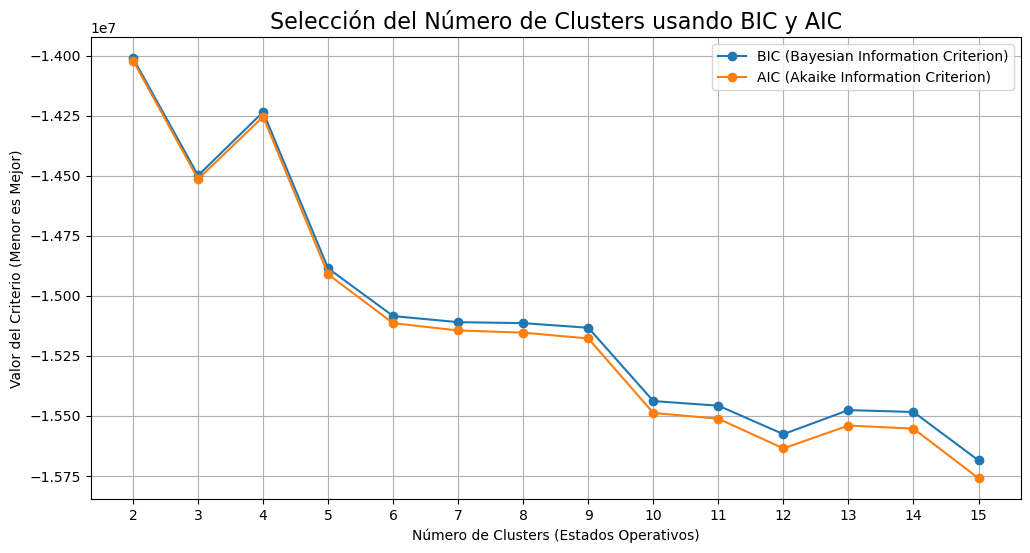

In [18]:
from tqdm import tqdm

print("Calculando los scores BIC y AIC para diferentes números de clusters...")

# Usaremos una muestra de los vectores latentes para que este proceso sea rápido
n_samples_for_bic = min(50000, len(latent_vectors)) # Usar hasta 50k puntos
latent_vectors_sample = latent_vectors[np.random.choice(len(latent_vectors), n_samples_for_bic, replace=False)]

# Rango de clusters a probar
n_components = np.arange(2, 16) 
bics = []
aics = []

for n in tqdm(n_components, desc="Probando N Clusters"):
    gmm = GaussianMixture(n_components=n, n_init=5, random_state=42)
    gmm.fit(latent_vectors_sample)
    bics.append(gmm.bic(latent_vectors_sample))
    aics.append(gmm.aic(latent_vectors_sample))

print("Cálculo completado.")

# --- Visualización de la Prueba del Codo ---
plt.figure(figsize=(12, 6))
plt.plot(n_components, bics, marker='o', label='BIC (Bayesian Information Criterion)')
plt.plot(n_components, aics, marker='o', label='AIC (Akaike Information Criterion)')
plt.title('Selección del Número de Clusters usando BIC y AIC', fontsize=16)
plt.xlabel('Número de Clusters (Estados Operativos)')
plt.ylabel('Valor del Criterio (Menor es Mejor)')
plt.xticks(n_components)
plt.legend()
plt.grid(True)
plt.show()

## Paso 7: Entrenamiento del GMM (El "Cerebro")

El GMM aprenderá a clusterizar los vectores de memoria para identificar los diferentes "estados operativos normales" del horno.

In [ ]:
# Decidimos el número de clusters (estados) a buscar. Esto es un hiperparámetro.
N_CLUSTERS = 6

print(f"Entrenando el GMM con {N_CLUSTERS} clusters...")
gmm = GaussianMixture(n_components=N_CLUSTERS, n_init=10, random_state=42)
gmm.fit(latent_vectors)
print("GMM entrenado.")

Entrenando el GMM con 6 clusters...
GMM entrenado.


## Paso 8: Detección y Visualización de Anomalías

Ahora, aplicamos nuestro sistema de dos niveles a un `HEATID` de ejemplo para ver cómo funciona:
1.  **Anomalía de Reconstrucción:** Si el Autoencoder no puede "dibujar" la secuencia correctamente, el error es alto. Esto significa que la forma de la secuencia es anómala.
2.  **Anomalía de Estado:** Si la secuencia es reconstruida correctamente pero su "vector de memoria" no encaja en ningún cluster normal del GMM, es un estado operativo anómalo.

In [20]:
# Seleccionar un HEATID de ejemplo de los que usamos para entrenar
example_heatid = selected_heatids[0]
df_example = df[df['HEATID'] == example_heatid]

# Crear secuencias solo para este HEATID
example_data = df_example[features].values
example_sequences = []
if len(example_data) >= TIME_STEPS:
    for i in range(len(example_data) - TIME_STEPS + 1):
        example_sequences.append(example_data[i:i+TIME_STEPS])
example_sequences = np.array(example_sequences)

# 1. Calcular error de reconstrucción
reconstructed_sequences = autoencoder.predict(example_sequences)
reconstruction_error = np.mean(np.square(example_sequences - reconstructed_sequences), axis=(1, 2))

# 2. Extraer vectores latentes y calcular score del GMM
example_latent_vectors = encoder_model.predict(example_sequences)
gmm_scores = gmm.score_samples(example_latent_vectors)

# 3. Definir umbrales (ej. percentil 99 para errores, percentil 1 para scores)
reconstruction_threshold = np.quantile(reconstruction_error, 0.99)
gmm_threshold = np.quantile(gmm_scores, 0.01)

# 4. Identificar anomalías
reconstruction_anomalies = reconstruction_error > reconstruction_threshold
state_anomalies = gmm_scores < gmm_threshold

# 5. Preparar datos para visualización
df_plot = df_example.iloc[TIME_STEPS-1:].copy()
df_plot['Reconstruction_Error'] = reconstruction_error
df_plot['GMM_Score'] = gmm_scores
df_plot['Reconstruction_Anomaly'] = reconstruction_anomalies
df_plot['State_Anomaly'] = state_anomalies

print(f"\nAnálisis para HEATID {example_heatid}:")
print(f"Umbral de Reconstrucción (MSE): {reconstruction_threshold:.6f}")
print(f"Umbral de Estado (Log-Probabilidad GMM): {gmm_threshold:.4f}")
print(f"Anomalías de Reconstrucción encontradas: {np.sum(reconstruction_anomalies)}")
print(f"Anomalías de Estado encontradas: {np.sum(state_anomalies)}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Análisis para HEATID 7F7006:
Umbral de Reconstrucción (MSE): 0.001628
Umbral de Estado (Log-Probabilidad GMM): 22.5816
Anomalías de Reconstrucción encontradas: 1
Anomalías de Estado encontradas: 1


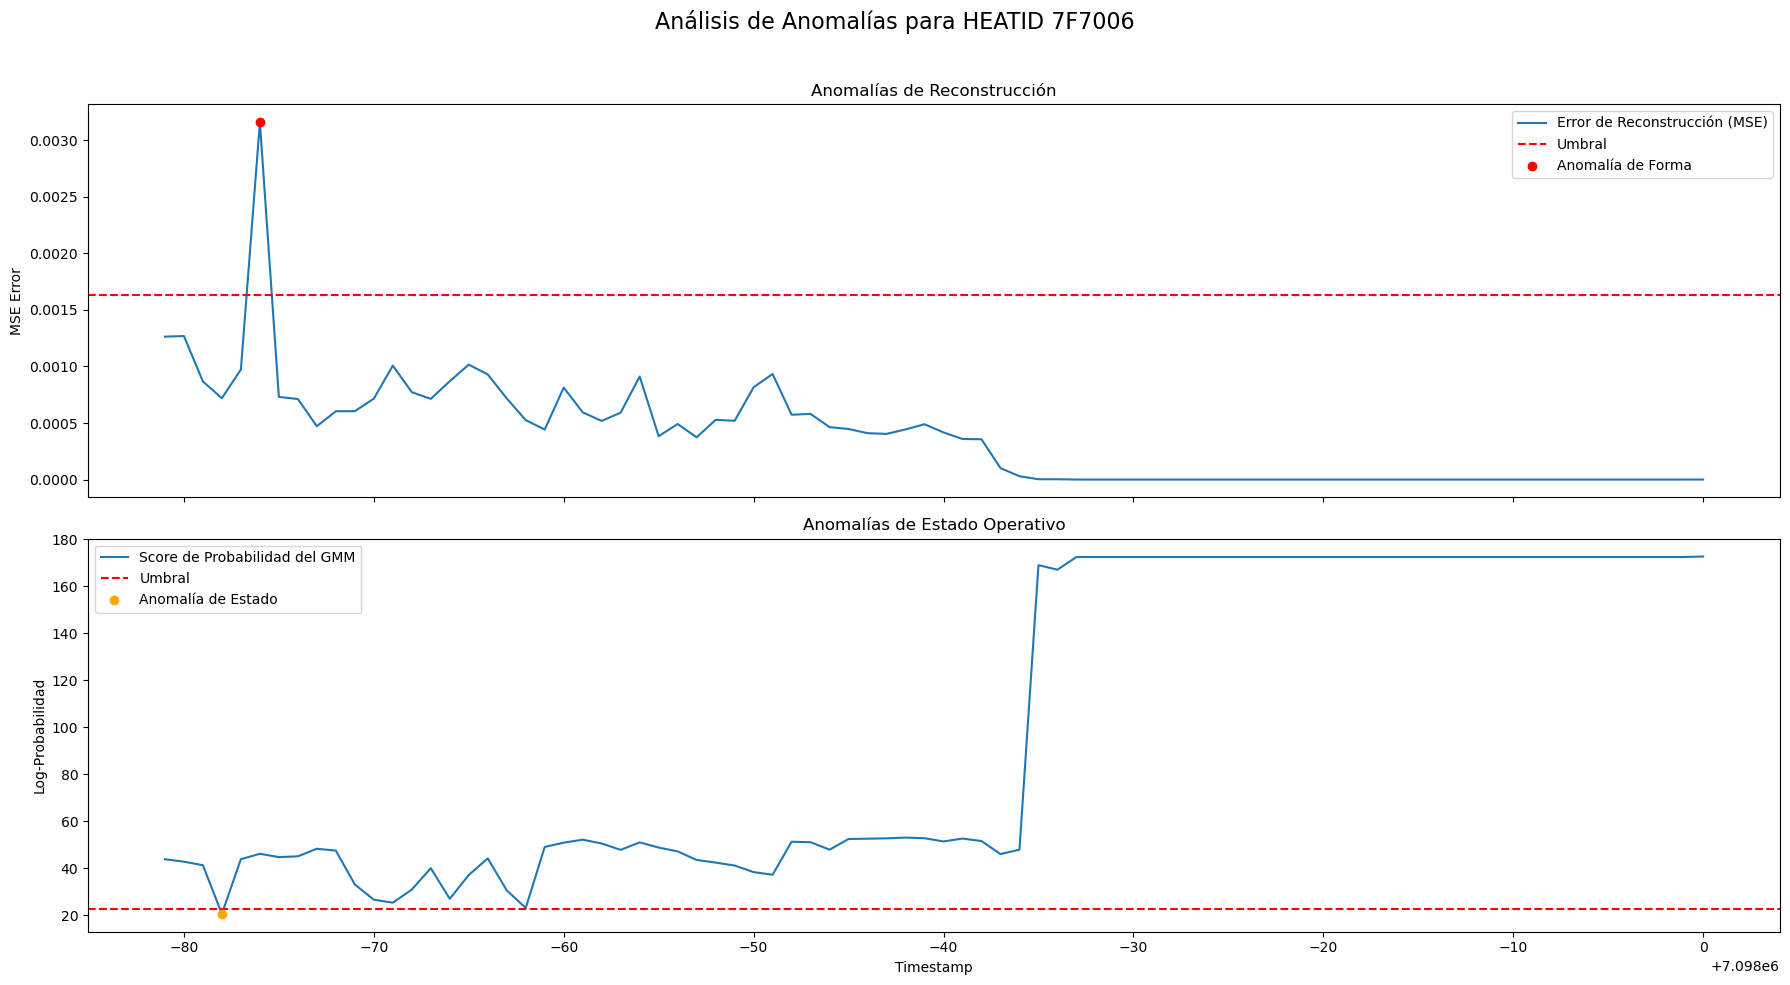

In [31]:
# Visualizar los resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
fig.suptitle(f'Análisis de Anomalías para HEATID {example_heatid}', fontsize=16)

# Gráfico del Error de Reconstrucción
ax1.plot(df_plot.index, df_plot['Reconstruction_Error'], label='Error de Reconstrucción (MSE)')
ax1.axhline(reconstruction_threshold, color='r', linestyle='--', label='Umbral')
ax1.scatter(df_plot.index[df_plot['Reconstruction_Anomaly']], df_plot['Reconstruction_Error'][df_plot['Reconstruction_Anomaly']], color='red', label='Anomalía de Forma', zorder=5)
ax1.set_title(f'Anomalías de Reconstrucción')
ax1.set_ylabel('MSE Error')
ax1.legend()

# Gráfico del Score del GMM
ax2.plot(df_plot.index, df_plot['GMM_Score'], label='Score de Probabilidad del GMM')
ax2.axhline(gmm_threshold, color='r', linestyle='--', label='Umbral')
ax2.scatter(df_plot.index[df_plot['State_Anomaly']], df_plot['GMM_Score'][df_plot['State_Anomaly']], color='orange', label='Anomalía de Estado', zorder=5)
ax2.set_title(f'Anomalías de Estado Operativo')
ax2.set_ylabel('Log-Probabilidad')
ax2.set_xlabel('Timestamp')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Una de las graficas mide el MSE, el cual saca la diferencia de error entre los datos originales con los datos reconstruidos, lo que detecta son anomalias de forma.

Por otro lado el Log-Probabilidad es nuestro estado de memoria (el resumen de la LSTM) dentro de los clusters del GMM. Cuando estos pasan a ser negativos, es cuando se detecta la anomalia un valor que este por debajo de la percepción de la realidad del modelo (contexto).

- Umbral, el margen de error de nuestro modelo.

- Error de Reconstrucción, es basicamente nuestra medida para saber que tan confundido esta el modelo, dando asi las anomalias en el camino.

Visualizando la primera anomalía encontrada en el timestamp: 7097924


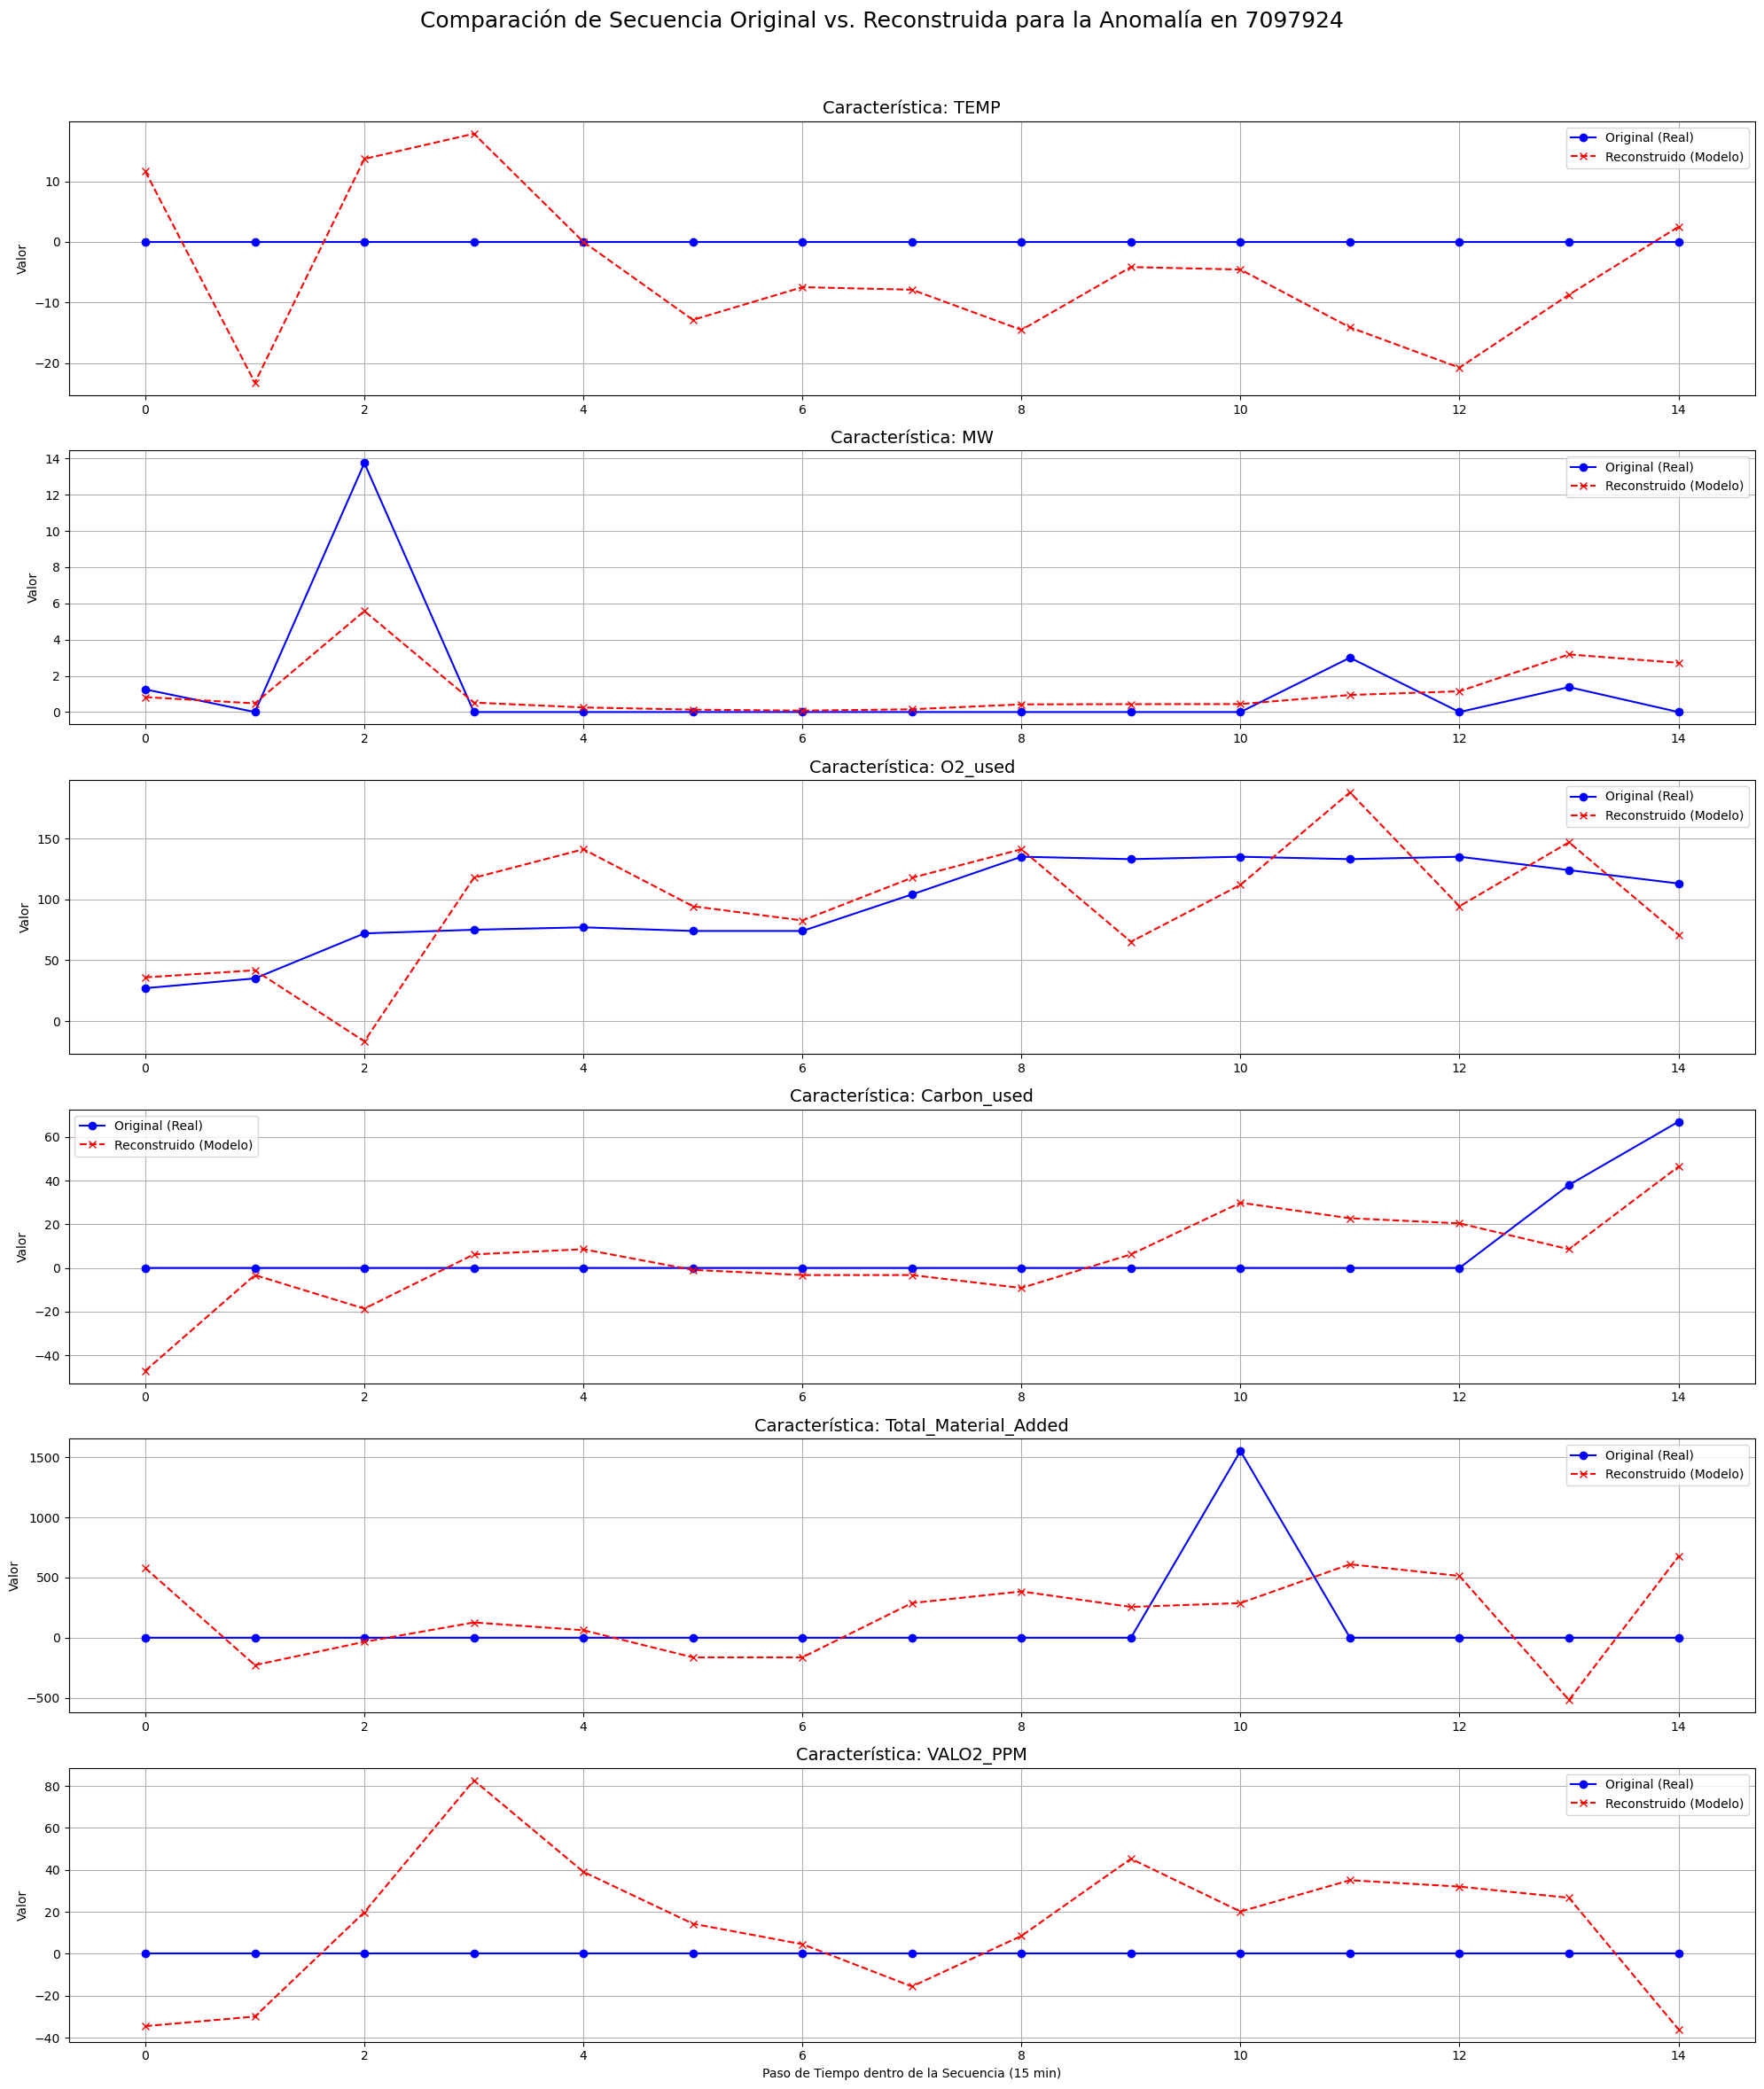

In [22]:
if np.any(df_plot['Reconstruction_Anomaly']):
    # Encontrar el índice de la primera anomalía detectada por el error de reconstrucción
    first_anomaly_index = df_plot[df_plot['Reconstruction_Anomaly']].index[0]

    # Mapear el índice del DataFrame al índice del array de secuencias
    # Usamos .get_loc() para obtener la posición numérica del índice de fecha y hora
    sequence_index = df_plot.index.get_loc(first_anomaly_index)

    print(f"Visualizando la primera anomalía encontrada en el timestamp: {first_anomaly_index}")

    # Obtener la secuencia original y la reconstruida (aún están escaladas)
    original_sequence_scaled = example_sequences[sequence_index]
    reconstructed_sequence_scaled = reconstructed_sequences[sequence_index]

    # --- Paso Clave: Revertir la normalización para interpretar los resultados ---
    original_sequence = scaler.inverse_transform(original_sequence_scaled)
    reconstructed_sequence = scaler.inverse_transform(reconstructed_sequence_scaled)

    # Convertir a DataFrames para facilitar el manejo y el ploteo
    df_original = pd.DataFrame(original_sequence, columns=features)
    df_reconstructed = pd.DataFrame(reconstructed_sequence, columns=features)

    # --- Visualización ---
    # Seleccionar algunas de las características más importantes para no saturar el gráfico
    features_to_plot = ['TEMP', 'MW', 'O2_used', 'Carbon_used', 'Total_Material_Added', 'VALO2_PPM']
    
    # Filtrar en caso de que alguna característica no esté en el dataframe (por si acaso)
    features_to_plot = [f for f in features_to_plot if f in df_original.columns]

    n_features_to_plot = len(features_to_plot)
    plt.figure(figsize=(20, 4 * n_features_to_plot))
    plt.suptitle(f'Comparación de Secuencia Original vs. Reconstruida para la Anomalía en {first_anomaly_index}', fontsize=18)

    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_features_to_plot, 1, i + 1)
        plt.plot(df_original.index, df_original[feature], 'b-o', label='Original (Real)')
        plt.plot(df_reconstructed.index, df_reconstructed[feature], 'r--x', label='Reconstruido (Modelo)')
        plt.title(f'Característica: {feature}', fontsize=14)
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)

    plt.xlabel('Paso de Tiempo dentro de la Secuencia (15 min)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("No se encontraron anomalías de reconstrucción en el HEATID de ejemplo para visualizar.")


# Paso 9. Análisis de Inteligencia Operativa

Ahora que tenemos los clusters, vamos a darles significado y analizar el flujo del proceso.

Cargando datos originales para la caracterización de clusters...


Creando secuencias originales sin escalar: 100%|██████████| 200/200 [00:00<00:00, 1323.68it/s]



--- Perfil Promedio de los Clusters (con Unidades Reales) ---


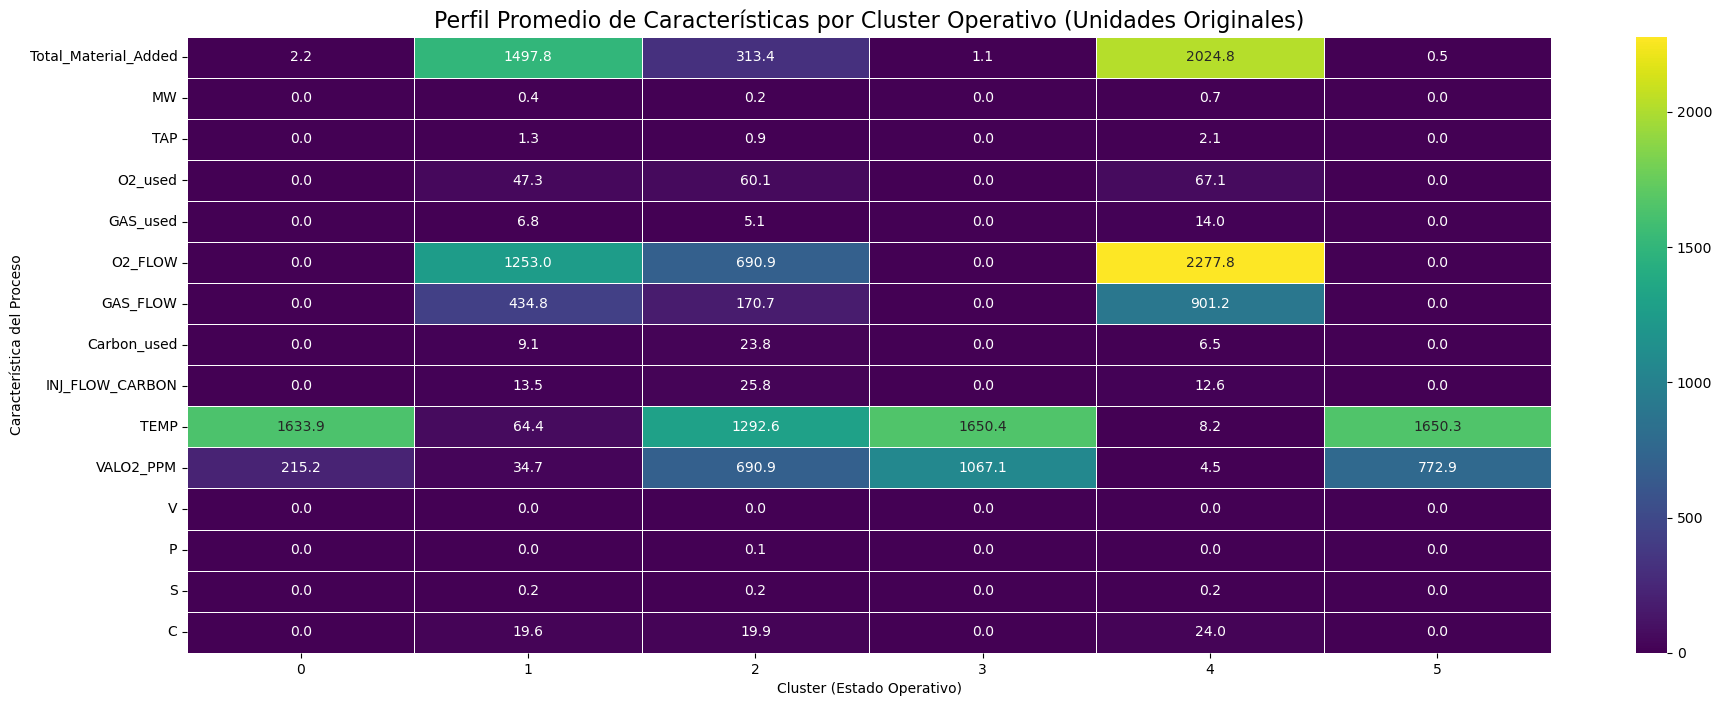

In [32]:
from tqdm import tqdm

# --- PASO 1: CARACTERIZACIÓN DE CLUSTERS (Versión Corregida con Datos Reales) ---

# Primero, asignamos cada vector latente a un cluster
cluster_labels = gmm.predict(latent_vectors)

# --- INICIO DE LA MODIFICACIÓN ---
# Vamos a cargar los datos originales SIN escalar para la interpretación
print("Cargando datos originales para la caracterización de clusters...")
df_original = pd.read_csv(FILE_PATH)

# Aplicamos el mismo filtro de HEATIDs que usamos para entrenar, si aplica
if N_HEATIDS_TO_USE is not None:
    # Asegurémonos de que 'selected_heatids' exista. Si no, lo recreamos.
    if 'selected_heatids' not in locals():
        unique_heatids = df['HEATID'].unique()
        selected_heatids = np.random.choice(unique_heatids, N_HEATIDS_TO_USE, replace=False)
    df_original = df_original[df_original['HEATID'].isin(selected_heatids)]

features_original = [col for col in df_original.columns if col not in ['Timestamp', 'HEATID']]

# Crear secuencias de los datos originales SIN ESCALAR
original_unscaled_sequences = []
grouped_original = df_original.groupby('HEATID')

for _, group in tqdm(grouped_original, desc="Creando secuencias originales sin escalar"):
    ts_data = group[features_original].values
    if len(ts_data) >= TIME_STEPS:
        for i in range(len(ts_data) - TIME_STEPS + 1):
            original_unscaled_sequences.append(ts_data[i:(i + TIME_STEPS)])

original_unscaled_sequences = np.array(original_unscaled_sequences)
# --- FIN DE LA MODIFICACIÓN ---

if len(original_unscaled_sequences) == len(cluster_labels):
    avg_sequence_values_unscaled = np.mean(original_unscaled_sequences, axis=1)
    df_avg_sequences_unscaled = pd.DataFrame(avg_sequence_values_unscaled, columns=features_original)
    df_avg_sequences_unscaled['cluster'] = cluster_labels

    # Calcular el perfil promedio para cada cluster con valores reales
    cluster_profiles = df_avg_sequences_unscaled.groupby('cluster').mean()

    print("\n--- Perfil Promedio de los Clusters (con Unidades Reales) ---")
    # Usamos un mapa de calor para visualizar los perfiles
    plt.figure(figsize=(22, 8))
    sns.heatmap(cluster_profiles.T, cmap='viridis', annot=True, fmt='.1f', linewidths=.5)
    plt.title('Perfil Promedio de Características por Cluster Operativo (Unidades Originales)', fontsize=16)
    plt.xlabel('Cluster (Estado Operativo)')
    plt.ylabel('Característica del Proceso')
    plt.show()
else:
    print(f"Error de longitud: No se pudieron alinear las secuencias originales ({len(original_unscaled_sequences)}) con las etiquetas de cluster ({len(cluster_labels)}).")


- Cluster 1 y 4: Fases de Carga de Material

Evidencia: Son los únicos con adiciones significativas de Total_Material_Added (1497 y 2024 Kg). Ambos tienen TEMP muy bajas (64°C y 8°C) y MW casi nulo.

Significado: Representan inequívocamente los momentos de carga de chatarra en un horno frío o tibio, antes de aplicar la potencia principal.

- Cluster 2: Fase de Refinamiento Químico

Evidencia: TEMP alta (1292°C), Carbon_used muy alto (23.7), y MW mínimo (0.2).

Significado: Es un estado de refinamiento donde el calor no proviene de la energía eléctrica, sino de reacciones químicas exotérmicas (ej. oxígeno + carbón) para ajustar la composición del metal.

- Cluster 0, 3 y 5: Fases de "Espera en Caliente" (Holding)

Evidencia: Todos tienen MW de 0.0, pero TEMP extremadamente altas (entre 1633°C y 1650°C).

Significado: Representan momentos en que el horno está en espera con el metal ya fundido y a alta temperatura. La energía está apagada, probablemente mientras se esperan resultados de análisis o se prepara el siguiente paso. Se distinguen entre sí por sus diferentes niveles de VALO2_PPM (oxidación), indicando distintos puntos en las etapas finales del proceso.

In [33]:
# Imprimirlo pero en texto
print("\n--- Perfil Promedio de los Clusters (con Unidades Reales) ---")
print(cluster_profiles)


--- Perfil Promedio de los Clusters (con Unidades Reales) ---
         Total_Material_Added        MW       TAP    O2_used   GAS_used  \
cluster                                                                   
0                    2.163505  0.000000  0.000000   0.000706   0.000099   
1                 1497.832638  0.352134  1.279116  47.336113   6.838294   
2                  313.388710  0.204083  0.902537  60.103544   5.129394   
3                    1.105159  0.000000  0.000000   0.000957   0.000310   
4                 2024.815022  0.704329  2.114024  67.105139  13.984737   
5                    0.487412  0.000000  0.000000   0.001040   0.000202   

             O2_FLOW    GAS_FLOW  Carbon_used  INJ_FLOW_CARBON         TEMP  \
cluster                                                                       
0           0.000000    0.000000     0.024587         0.000000  1633.907736   
1        1253.029023  434.771126     9.055451        13.478522    64.421699   
2         690.911490


Realizando reducción de dimensionalidad con t-SNE para visualización...
Visualizando el mapa de estados operativos...


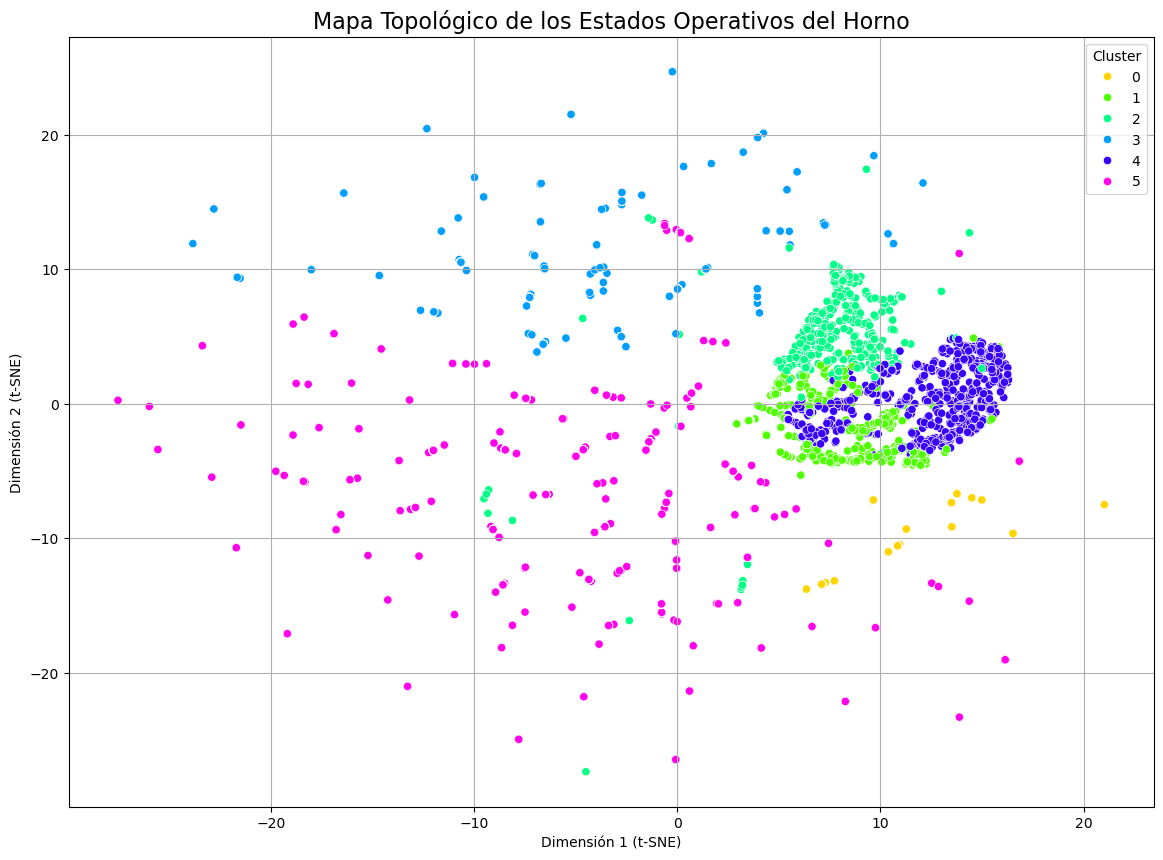

In [25]:
# --- PASO 3: ANÁLISIS TOPOLÓGICO VISUAL (con t-SNE) ---
from sklearn.manifold import TSNE

print("\nRealizando reducción de dimensionalidad con t-SNE para visualización...")
# Usamos una muestra de los vectores latentes para acelerar el t-SNE
sample_indices = np.random.choice(len(latent_vectors), size=min(10000, len(latent_vectors)), replace=False)
latent_vectors_sample = latent_vectors[sample_indices]
cluster_labels_sample = cluster_labels[sample_indices]

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(latent_vectors_sample)

print("Visualizando el mapa de estados operativos...")
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cluster_labels_sample,
    palette=sns.color_palette("hsv", N_CLUSTERS),
    legend="full"
)
plt.title('Mapa Topológico de los Estados Operativos del Horno', fontsize=16)
plt.xlabel('Dimensión 1 (t-SNE)')
plt.ylabel('Dimensión 2 (t-SNE)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()